In [1]:
%matplotlib inline

In [2]:
from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()
print(mock.keys())

Total runtime = 15.53 seconds
['obs_sfr', 'icl', 'upid', 'mpeak', 'sfr', 'halo_id', 'mvir', 'rvir', 'vmax_at_mpeak', 'vx', 'a_first_infall', 'sm', 'vy', 'y', 'x', 'vz', 'z', 'dvmax_zscore', 'obs_sm', 'halo_hostid', 'host_halo_rvir', 'host_halo_mvir', 'ssfr', 'is_main_sequence', 'is_green_valley', 'is_quenched', 'logsm', 'rvir_halo_kpc', 'rvir_halo_kpc_present_day', 'spin_at_infall', 'bt_meert15_random']


In [3]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]

disk_dominated_mask = sdss['bulge_to_total_rband_meert15'] < 0.25
bulge_dominated_mask = sdss['bulge_to_total_rband_meert15'] > 0.75
mixed_morphology_mask = ~disk_dominated_mask & ~bulge_dominated_mask


In [39]:
from galsize_models.models.bulge_disk_double_power_law import galaxy_size_vs_rhalo

norm_bulge = 0.002
bulge_to_disk_size_ratio = 1/7.
alpha_bulge = 1.25
alpha_disk = 1
scatter = 0.2

norm_disk = norm_bulge/bulge_to_disk_size_ratio

rvir_halo_kpc = mock['rvir_halo_kpc']
bt = mock['bt_meert15_random']

size_seed=14041

mock['r50_magr_kpc_meert15'] = galaxy_size_vs_rhalo(rvir_halo_kpc, bt, 
                    norm_bulge, norm_disk, 
                     alpha_bulge, alpha_disk, scatter=scatter, seed=size_seed)

bulge_dominated_mask_mock = mock['bt_meert15_random'] > 0.75
disk_dominated_mask_mock = mock['bt_meert15_random'] < 0.25
mixed_morphology_mask_mock = ~disk_dominated_mask_mock & ~bulge_dominated_mask_mock


from scipy.stats import binned_statistic
logsm_bins = np.linspace(9.75, 11.5, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_rhalf_bulge_mock, __, __ = binned_statistic(
        mock['obs_sm'][bulge_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15'][bulge_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_disk_mock, __, __ = binned_statistic(
        mock['obs_sm'][disk_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15'][disk_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_all_mock, __, __ = binned_statistic(
        mock['obs_sm'], mock['r50_magr_kpc_meert15'], bins=10**logsm_bins)
median_rhalf_mixed_mock, __, __ = binned_statistic(
        mock['obs_sm'][mixed_morphology_mask_mock], 
        mock['r50_magr_kpc_meert15'][mixed_morphology_mask_mock], bins=10**logsm_bins)


In [40]:
from astropy.cosmology import Planck15

mock['frac_dm_massloss'] = (mock['mvir'] - mock['mpeak'])/mock['mpeak']
size_reduction_mask = (mock['frac_dm_massloss'] < 0) & (mock['upid'] != -1)
frac_rvir_decrease = np.ones(len(mock))
frac_rvir_decrease[size_reduction_mask] = np.abs(mock['frac_dm_massloss'][size_reduction_mask])**(1/3.)

mock['rvir_halo_kpc_present_day'] = mock['rvir_halo_kpc']*frac_rvir_decrease
rvir_halo_kpc_present_day = mock['rvir_halo_kpc_present_day']

mock['r50_magr_kpc_meert15_max_sat_stripping'] = galaxy_size_vs_rhalo(rvir_halo_kpc_present_day, bt, 
                    norm_bulge, norm_disk, 
                     alpha_bulge, alpha_disk, scatter=scatter, seed=size_seed)

median_rhalf_bulge_mock_max_sat_stripping, __, __ = binned_statistic(
        mock['obs_sm'][bulge_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15_max_sat_stripping'][bulge_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_disk_mock_max_sat_stripping, __, __ = binned_statistic(
        mock['obs_sm'][disk_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15_max_sat_stripping'][disk_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_all_mock_max_sat_stripping, __, __ = binned_statistic(
        mock['obs_sm'], mock['r50_magr_kpc_meert15'], bins=10**logsm_bins)
median_rhalf_mixed_mock_max_sat_stripping, __, __ = binned_statistic(
        mock['obs_sm'][mixed_morphology_mask_mock], 
        mock['r50_magr_kpc_meert15_max_sat_stripping'][mixed_morphology_mask_mock], bins=10**logsm_bins)


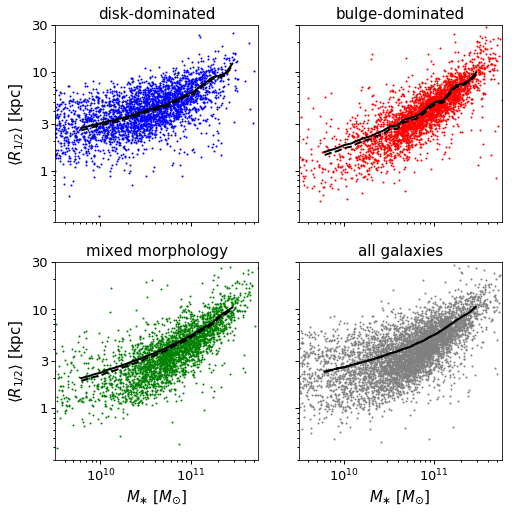

In [41]:
from matplotlib import ticker 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                              figsize=(8, 8))
axes = (ax1, ax2, ax3, ax4)

for ax in axes:
    __=ax.loglog()

__=ax1.scatter(10**sdss['sm'][disk_dominated_mask][::20], 
              sdss['r50_magr_kpc_meert15'][disk_dominated_mask][::20], 
             s=1, color='blue')
__=ax2.scatter(10**sdss['sm'][bulge_dominated_mask][::10], 
              sdss['r50_magr_kpc_meert15'][bulge_dominated_mask][::10], 
             s=1, color='red')
__=ax3.scatter(10**sdss['sm'][mixed_morphology_mask][::40], 
              sdss['r50_magr_kpc_meert15'][mixed_morphology_mask][::40], 
             s=1, color='green')
__=ax4.scatter(10**sdss['sm'][::40], sdss['r50_magr_kpc_meert15'][::40], 
             s=1, color='gray')


__=ax1.plot(10**logsm_mids, median_rhalf_disk_mock, color='k', lw=2)
__=ax2.plot(10**logsm_mids, median_rhalf_bulge_mock, color='k', lw=2)
__=ax3.plot(10**logsm_mids, median_rhalf_mixed_mock, color='k', lw=2)
__=ax4.plot(10**logsm_mids, median_rhalf_all_mock, color='k', lw=2)

__=ax1.plot(10**logsm_mids, median_rhalf_disk_mock_max_sat_stripping, '--',color='k', lw=2)
__=ax2.plot(10**logsm_mids, median_rhalf_bulge_mock_max_sat_stripping, '--', color='k', lw=2)
__=ax3.plot(10**logsm_mids, median_rhalf_mixed_mock_max_sat_stripping, '--', color='k', lw=2)
__=ax4.plot(10**logsm_mids, median_rhalf_all_mock_max_sat_stripping, '--', color='k', lw=2)


xmin, xmax = 10**9.5, 10**11.75
ymin, ymax = 0.3, 30
xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
for ax in axes:
    xlim = ax.set_xlim(xmin, xmax)
    ylim = ax.set_ylim(ymin, ymax)
    __=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_yticks((1, 3, 10, 30))

ylabel1=ax1.set_ylabel(ylabel)
__=ax3.set_ylabel(ylabel)
xlabel3=ax3.set_xlabel(xlabel)
__=ax4.set_xlabel(xlabel)

title1 = ax1.set_title(r'disk-dominated')
title2 = ax2.set_title(r'bulge-dominated')
title3 = ax3.set_title(r'mixed morphology')
title4 = ax4.set_title(r'all galaxies')




## Test clustering predictions

In [42]:
from galsize_models.measurements import wp_size_ratios_mock

logsm_min = 10.
rp_mids, wp_sm10p0_bulge, wp_sm10p0_bulge_small, wp_sm10p0_bulge_large = wp_size_ratios_mock(mock, logsm_min, 'bulge')
rp_mids, wp_sm10p0_disk, wp_sm10p0_disk_small, wp_sm10p0_disk_large = wp_size_ratios_mock(mock, logsm_min, 'disk')
rp_mids, wp_sm10p0_mixed, wp_sm10p0_mixed_small, wp_sm10p0_mixed_large = wp_size_ratios_mock(mock, logsm_min, 'mixed')

logsm_min = 10.5
rp_mids, wp_sm10p5_bulge, wp_sm10p5_bulge_small, wp_sm10p5_bulge_large = wp_size_ratios_mock(mock, logsm_min, 'bulge')
rp_mids, wp_sm10p5_disk, wp_sm10p5_disk_small, wp_sm10p5_disk_large = wp_size_ratios_mock(mock, logsm_min, 'disk')
rp_mids, wp_sm10p5_mixed, wp_sm10p5_mixed_small, wp_sm10p5_mixed_large = wp_size_ratios_mock(mock, logsm_min, 'mixed')

fracdiff_sm10p0_bulge_mock = (wp_sm10p0_bulge_large-wp_sm10p0_bulge_small)/wp_sm10p0_bulge
fracdiff_sm10p0_disk_mock = (wp_sm10p0_disk_large-wp_sm10p0_disk_small)/wp_sm10p0_disk
fracdiff_sm10p0_mixed_mock = (wp_sm10p0_mixed_large-wp_sm10p0_mixed_small)/wp_sm10p0_mixed

fracdiff_sm10p5_bulge_mock = (wp_sm10p5_bulge_large-wp_sm10p5_bulge_small)/wp_sm10p5_bulge
fracdiff_sm10p5_disk_mock = (wp_sm10p5_disk_large-wp_sm10p5_disk_small)/wp_sm10p5_disk
fracdiff_sm10p5_mixed_mock = (wp_sm10p5_mixed_large-wp_sm10p5_mixed_small)/wp_sm10p5_mixed

In [43]:
logsm_min = 10.
rp_mids, wp_sm10p0_bulge2, wp_sm10p0_bulge_small2, wp_sm10p0_bulge_large2 = wp_size_ratios_mock(mock, logsm_min, 'bulge',size_key='r50_magr_kpc_meert15_max_sat_stripping')
rp_mids, wp_sm10p0_disk2, wp_sm10p0_disk_small2, wp_sm10p0_disk_large2 = wp_size_ratios_mock(mock, logsm_min, 'disk',size_key='r50_magr_kpc_meert15_max_sat_stripping')
rp_mids, wp_sm10p0_mixed2, wp_sm10p0_mixed_small2, wp_sm10p0_mixed_large2 = wp_size_ratios_mock(mock, logsm_min, 'mixed',size_key='r50_magr_kpc_meert15_max_sat_stripping')

logsm_min = 10.5
rp_mids, wp_sm10p5_bulge2, wp_sm10p5_bulge_small2, wp_sm10p5_bulge_large2 = wp_size_ratios_mock(mock, logsm_min, 'bulge',size_key='r50_magr_kpc_meert15_max_sat_stripping')
rp_mids, wp_sm10p5_disk2, wp_sm10p5_disk_small2, wp_sm10p5_disk_large2 = wp_size_ratios_mock(mock, logsm_min, 'disk',size_key='r50_magr_kpc_meert15_max_sat_stripping')
rp_mids, wp_sm10p5_mixed2, wp_sm10p5_mixed_small2, wp_sm10p5_mixed_large2 = wp_size_ratios_mock(mock, logsm_min, 'mixed',size_key='r50_magr_kpc_meert15_max_sat_stripping')

fracdiff_sm10p0_bulge_mock2 = (wp_sm10p0_bulge_large2-wp_sm10p0_bulge_small2)/wp_sm10p0_bulge2
fracdiff_sm10p0_disk_mock2 = (wp_sm10p0_disk_large2-wp_sm10p0_disk_small2)/wp_sm10p0_disk2
fracdiff_sm10p0_mixed_mock2 = (wp_sm10p0_mixed_large2-wp_sm10p0_mixed_small2)/wp_sm10p0_mixed2

fracdiff_sm10p5_bulge_mock2 = (wp_sm10p5_bulge_large2-wp_sm10p5_bulge_small2)/wp_sm10p5_bulge2
fracdiff_sm10p5_disk_mock2 = (wp_sm10p5_disk_large2-wp_sm10p5_disk_small2)/wp_sm10p5_disk2
fracdiff_sm10p5_mixed_mock2 = (wp_sm10p5_mixed_large2-wp_sm10p5_mixed_small2)/wp_sm10p5_mixed2

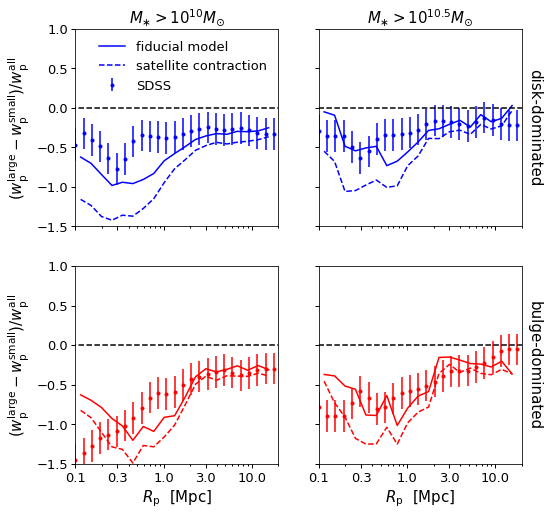

In [44]:
import os
repo_dirname = "/Users/aphearin/work/repositories/python/galsize_models"
output_subdirname = "galsize_models/measurements/data/two_point_functions"
output_dirname = os.path.join(repo_dirname, output_subdirname)

size_fracdiff_sm10p0_meert15_disk_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p0_meert15_disk_dom.npy'))
size_fracdiff_sm10p0_meert15_bulge_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p0_meert15_bulge_dom.npy'))
size_fracdiff_sm10p5_meert15_disk_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p5_meert15_disk_dom.npy'))
size_fracdiff_sm10p5_meert15_bulge_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p5_meert15_bulge_dom.npy'))

_rp_fname = os.path.join(output_dirname, 'sdss_sm10p0_rp.npy')
sdss_rp = np.load(_rp_fname)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                            sharex=True, sharey=True, figsize=(8, 8))

sdss_errors = np.zeros_like(sdss_rp) + 0.2
__=ax1.errorbar(sdss_rp, size_fracdiff_sm10p0_meert15_disk_dom, sdss_errors, 
                color='blue', fmt='.', label='SDSS')
__=ax2.errorbar(sdss_rp, size_fracdiff_sm10p5_meert15_disk_dom, sdss_errors, 
                color='blue', fmt='.')
__=ax3.errorbar(sdss_rp, size_fracdiff_sm10p0_meert15_bulge_dom, sdss_errors, 
                color='red', fmt='.')
__=ax4.errorbar(sdss_rp, size_fracdiff_sm10p5_meert15_bulge_dom, sdss_errors, 
                color='red', fmt='.')


__=ax1.plot(rp_mids, fracdiff_sm10p0_disk_mock, color='blue', 
            label='fiducial model')
__=ax2.plot(rp_mids, fracdiff_sm10p5_disk_mock, color='blue')
__=ax3.plot(rp_mids, fracdiff_sm10p0_bulge_mock, color='red')
__=ax4.plot(rp_mids, fracdiff_sm10p5_bulge_mock, color='red')
__=ax1.plot(rp_mids, fracdiff_sm10p0_disk_mock2,'--', color='blue', 
            label=r'satellite contraction')
__=ax2.plot(rp_mids, fracdiff_sm10p5_disk_mock2,'--', color='blue')
__=ax3.plot(rp_mids, fracdiff_sm10p0_bulge_mock2,'--', color='red')
__=ax4.plot(rp_mids, fracdiff_sm10p5_bulge_mock2,'--', color='red')

leg1 = ax1.legend()


xscale1 = ax1.set_xscale('log')
xscale2 = ax2.set_xscale('log')

__=ax1.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax2.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax3.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax4.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
xmin, xmax = 0.1, 20
ymin, ymax = -1.5, 1
xlim1 = ax1.set_xlim(xmin, xmax)
ylim1 = ax1.set_ylim(ymin, ymax)
xlim2 = ax2.set_xlim(xmin, xmax)
ylim2 = ax2.set_ylim(ymin, ymax)

title1 = ax1.set_title(r'$M_{\ast} > 10^{10}M_{\odot}$')
title2 = ax2.set_title(r'$M_{\ast} > 10^{10.5}M_{\odot}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')

__=ax2.yaxis.set_label_position("right")
ylabel2 = ax2.set_ylabel('disk-dominated', rotation=-90, labelpad=20)
__=ax4.yaxis.set_label_position("right")
ylabel4 = ax4.set_ylabel('bulge-dominated', rotation=-90, labelpad=20)

__=ax1.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax2.set_xticks((0.1, 0.3, 1, 3, 10))
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

figname = 'alternate_satellite_models_size_clustering_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel1], bbox_inches='tight')


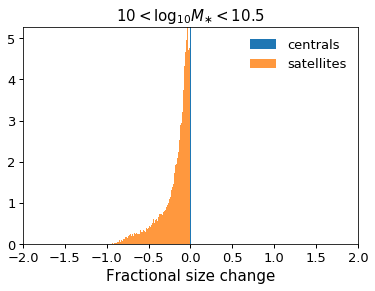

In [45]:
logsm_low, logsm_high = 10, 10.5
sm_mask = (mock['obs_sm'] >= 10**logsm_low) & (mock['obs_sm'] < 10**logsm_high)
cen_sm_mask = sm_mask & (mock['upid'] == -1)
cens = mock[cen_sm_mask]
sat_sm_mask = sm_mask & (mock['upid'] != -1)
sats = mock[sat_sm_mask]

fig, ax = plt.subplots(1, 1)

cen_rhalf_fracdiff = (cens['r50_magr_kpc_meert15_max_sat_stripping']-cens['r50_magr_kpc_meert15'])/cens['r50_magr_kpc_meert15']
sat_rhalf_fracdiff = (sats['r50_magr_kpc_meert15_max_sat_stripping']-sats['r50_magr_kpc_meert15'])/sats['r50_magr_kpc_meert15']

__=ax.hist(cen_rhalf_fracdiff, bins=150,normed=True, label='centrals')
__sat=ax.hist(sat_rhalf_fracdiff, bins=150, alpha=0.8,normed=True, label='satellites')

xlim = ax.set_xlim(-2,2)
ylim = ax.set_ylim(0,__sat[0].max())
xlabel = ax.set_xlabel(r'Fractional size change')
title = ax.set_title(r'$10 < \log_{10}M_{\ast} < 10.5$')
legend = ax.legend()